Cargamos las librerías (Numpy y matplotlib-pyplot) y definimos los parámetros del problema.

In [ ]:
###############################################################
#  Implementación numérica de Bruinsma.
#  Miriam Gutiérrez UDC
###############################################################
from numpy import *
import matplotlib.pyplot as plt

#
#  Definición de parámetros
#

kBT = 1.38e-23*310.          # Boltzmann's Constant times temperature

rhof = 1e-9                  # Range of the biding potential (1 nm)

gammaB = 1e4*1e-12/1e-9       # Viscous drag in the ECM (1e4 pN /(nm/s))
gammaR = gammaB               # Viscous drag in the cytoplasm
kecm = gammaR                 # Elastic recovery in the ECM

T = 10e-9                    # Traction force acting on the actin bundle [10 nN]
VR = T / gammaR              # Terminal velocity of the actin bundle

DU = 2.*rhof*T              # Activation energy (amp. of the potential weel)

sqrtsigmaB = 0.07*gammaB*T  #Intensity of the thermal noise for the FA
sqrtsigmaR = sqrtsigmaB    #Intensity of the thermal noise for the actin bundle


Modelo estocastico:
\begin{eqnarray*}
    \gamma_B  \frac{dX}{dt} +kX = \frac{dU(\rho,S)}{d\rho} + f(t) \\
    \gamma_R \frac{dZ}{dt}  = \frac{dU(\rho,S)}{d\rho} + T + f^* (t)
\end{eqnarray*}

Definimos los parámetros de la integración numérica y las condiciones iniciales

In [ ]:
# Define the time vector for the integration
tBegin = 0.
tEnd = 100.
dt = (tEnd - tBegin) / 100000.

t = arange(tBegin, tEnd, dt)
N = t.size          #100000
sqrtdt = sqrt(dt)  # Square root of dt, needed for the stochastic term

# Initialize the vectors
x = zeros(N)
z = zeros_like(x)
rho = zeros_like(x)

x[0] = 0.
z[0] = -10. * rhof


Método de Euler explícito que integra las ecuaciones.

In [ ]:
for i in arange(1, N):
    # Fuerza de interacción (gradiente del potencial)
    force = 2 * DU / rhof**2 * (z[i-1] - x[i-1]) * exp(-((z[i-1] - x[i-1])**2) / rhof**2)

    # Términos estocásticos
    fz = random.normal(loc=0.0, scale=1.0) * sqrtsigmaR * sqrtdt
    fx = random.normal(loc=0.0, scale=1.0) * sqrtsigmaB * sqrtdt

    # Ecuación para z
    z[i] = z[i-1] + dt * (T - force) / gammaR + fz / gammaR

    # Ecuación para x
    x[i] = x[i-1] + dt * (-kecm * x[i-1] + force) / gammaB + fx / gammaB

    # Imprimir resultados (en notación científica)
    #print(i, i*dt, x, z, fz, fx)

# Calcular el slip final
rho = z - x


Llevamos a cabo la integración temporal usando Euler-Maruyama.

In [ ]:
for i in arange(1, N):
    # Define rho = Z-X
    rho = z[i-1] - x[i-1]

    dU = 2. * DU * rho / rhof**2 * exp(-(rho / rhof)**2)

    x[i] = x[i-1] + dt * (-kecm * x[i-1] + dU) / gammaB + sqrtsigmaB * sqrtdt * random.normal(loc=0.0, scale=1.0) / gammaB

    z[i] = z[i-1] + dt * (-dU + T) / gammaR +  sqrtsigmaR * sqrtdt * random.normal(loc=0.0, scale=1.0) / gammaR

# Compute the slip
rho = z - x


Representamos los resultados


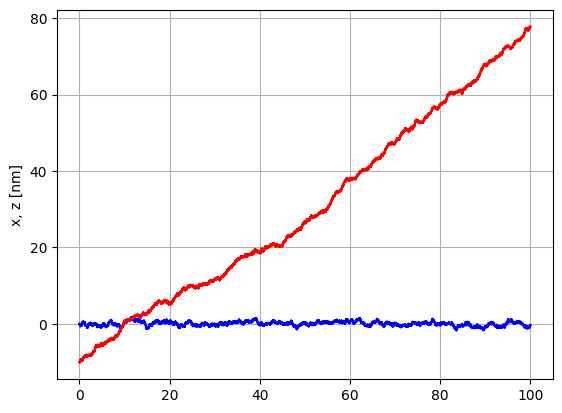

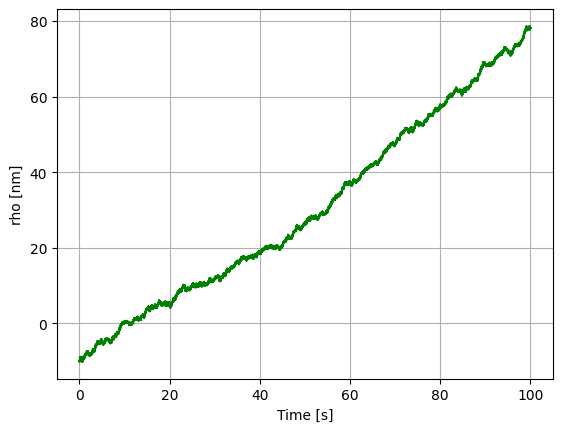

In [ ]:
plt.figure(1)
plt.clf()
plt.plot(t, x / 1e-9, 'b', t, z / 1e-9, 'r')
plt.grid('on')
plt.ylabel('x, z [nm]')

plt.figure(2)
plt.clf()
plt.plot(t, rho / 1e-9, 'g')
plt.grid('on')
plt.xlabel('Time [s]')
plt.ylabel('rho [nm]')

plt.show()

Automatizamos el algoritmo para calcular el tiempo medio de vida de la adhesión focal, es decir el tiempo durante el cual $\rho < \rho_f$.


In [ ]:
tiempo_episodio = 0.0
episodios = []
dentro = False  # ¿Está en un episodio con |rho| < rhof?

# Bucle Euler–Maruyama
for i in arange(1, N):
    # Calcular rho actual
    rho = z[i-1] - x[i-1]

    # Gradiente del potencial
    dU = 2. * DU * rho / rhof**2 * exp(-(rho / rhof)**2)

    # Euler-Maruyama
    x[i] = x[i-1] + dt * (-kecm * x[i-1] + dU) / gammaB + \
           sqrtsigmaB * sqrtdt * random.normal(0.0, 1.0) / gammaB

    z[i] = z[i-1] + dt * (-dU + T) / gammaR + \
           sqrtsigmaR * sqrtdt * random.normal(0.0, 1.0) / gammaR

    # Cálculo de duración de adhesión focal activa
    if abs(rho) < rhof:
        tiempo_episodio += dt
        dentro = True
    else:
        if dentro:
            episodios.append(tiempo_episodio)
            tiempo_episodio = 0.0
            dentro = False

# Si el último paso fue parte de un episodio activo, lo añadimos
rho_final = z[-1] - x[-1]
if abs(rho_final) < rhof and dentro:
    episodios.append(tiempo_episodio)

# Calcular tiempo medio de vida
if len(episodios) > 0:
    t_medio = mean(episodios)
    print(f"Tiempo medio de vida de la adhesión focal: {t_medio:.3e} s")
else:
    print("No se detectaron episodios de adhesión focal (|rho| < rhof).")

# Calcular el slip total por si lo necesitas después
rho = z - x


Tiempo medio de vida de la adhesión focal: 7.226e-01 s


Modificamos todo lo anterior para verificar el efecto de la rigidez de la matriz k

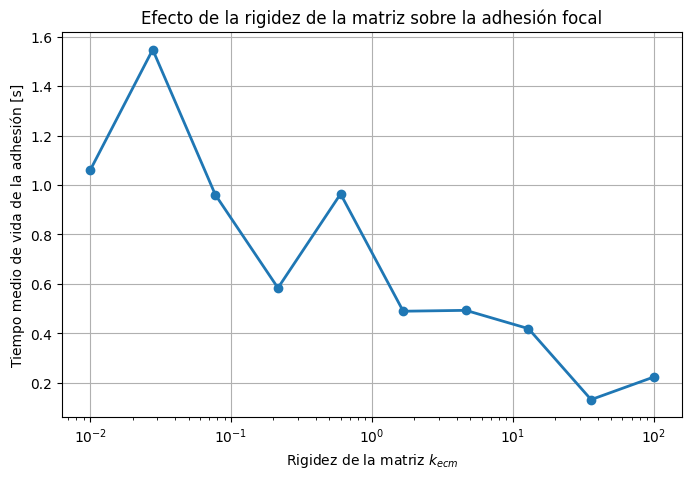

In [ ]:
# Rango de rigideces
k_vals = logspace(-2, 2, 10)  # de 1e-2 a 1e2
tiempos_medios = []

for kecm in k_vals:
    x = zeros(N)
    z = zeros_like(x)

    x[0] = 0.0
    z[0] = -10 * rhof

    tiempo_episodio = 0.0
    episodios = []
    dentro = False

    for i in arange(1, N):
        rho = z[i-1] - x[i-1]
        dU = 2. * DU * rho / rhof**2 * exp(-(rho / rhof)**2)

        x[i] = x[i-1] + dt * (-kecm * x[i-1] + dU) / gammaB + \
               sqrtsigmaB * sqrtdt * random.normal(0.0, 1.0) / gammaB

        z[i] = z[i-1] + dt * (-dU + T) / gammaR + \
               sqrtsigmaR * sqrtdt * random.normal(0.0, 1.0) / gammaR

        if abs(rho) < rhof:
            tiempo_episodio += dt
            dentro = True
        else:
            if dentro:
                episodios.append(tiempo_episodio)
                tiempo_episodio = 0.0
                dentro = False

    rho_final = z[-1] - x[-1]
    if abs(rho_final) < rhof and dentro:
        episodios.append(tiempo_episodio)

    if len(episodios) > 0:
        t_medio = mean(episodios)
    else:
        t_medio = 0.0

    tiempos_medios.append(t_medio)

# Resultados
plt.figure(figsize=(8,5))
plt.semilogx(k_vals, tiempos_medios, 'o-', lw=2)
plt.xlabel('Rigidez de la matriz $k_{ecm}$')
plt.ylabel('Tiempo medio de vida de la adhesión [s]')
plt.grid('on')
plt.title('Efecto de la rigidez de la matriz sobre la adhesión focal')
plt.show()

Comparación gráfica de las soluciones estacionarias dependiendo del valor de $T$.

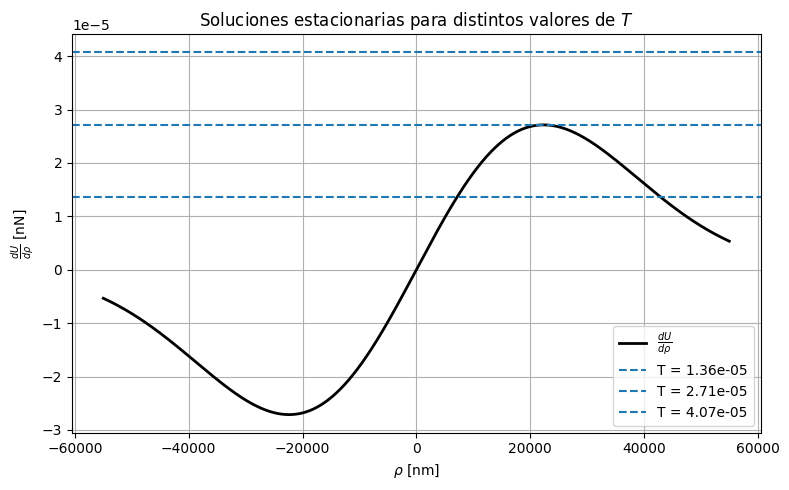

In [ ]:
# Función de la derivada del potencial
def dUdrho(rho):
    return (2 * rho / rhof) * 1e-18 * exp(-rho**2 / rhof)
rho = linspace(-5.5e-5, 5.5e-5, 1000)

# Recalcular valores
dU_vals = dUdrho(rho)
T_max = max(dU_vals)
T_vals = [0.5 * T_max, T_max, 1.5 * T_max]

# Graficar
plt.figure(figsize=(8,5))
plt.plot(rho * 1e9, dU_vals * 1e9, label=r"$\frac{dU}{d\rho}$", color='black', linewidth=2)

for T in T_vals:
    plt.axhline(T * 1e9, linestyle='--', label=f"T = {T*1e9:.2e}")

plt.xlabel(r"$\rho$ [nm]")
plt.ylabel(r"$\frac{dU}{d\rho}$ [nN]")
plt.title("Soluciones estacionarias para distintos valores de $T$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()